## GMSNet_kataoka_nishimura_fixing test.ipynb を元に、使用感を高めるために改良する






testを実行するためのコード

# シフト切り捨てをやめてみる
# トレーニング完了後のトレーニングメッシュを表示してみる
# 各epochの終了時にメッシュを可視化してみる

In [1]:
import copy
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphNorm, LayerNorm
import torch_geometric.transforms as T
from torch.nn import Linear, InstanceNorm2d, InstanceNorm1d, Conv1d, ReLU, Tanh
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.pyplot as plt
from torch_geometric.transforms import FaceToEdge
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from itertools import combinations
import vtk
import glob
from tqdm import tqdm
# 計算を軽くするためのライブラリ
from torch.cuda import empty_cache
import gc               # メモリリークを防ぐ

from torch import nn
import os
import sys

import datetime
import imageio

In [2]:
torch.cuda.is_available()

True

In [3]:
test_data_path = "/mnt/Test_Data/"
fig_save_path = "/mnt/Optimized_mesh_Folder/"
vtk_save_path = "/mnt/optimized_data/"

In [4]:
num_test_epoch = 50
num_trial = 5

# Dataの準備

In [5]:
class Dataset(Dataset):
    def __init__(self, num_files):
        None

class Mesh(Dataset):
    def __init__(self):
        self.coordinates = None
        self.faces = None

class Polygon(Dataset):
    def __init__(self, num_node, num_face):
        self.parent_meshID = None
        self.coordinates = torch.zeros(num_node, 2)
        self.faces = torch.zeros(num_face, 3)
        self.edges = None
        self.d = None
        self.Cx = None
        self.Cy = None
        self.x_min = None
        self.y_min = None

class PolygonID(Dataset):
    def __init__(self, nodeID):
        self.nodeID = nodeID

class Polygon_data(Dataset):
    def __init__(self, polygonID, meshID, nodeID):
        self.polygonID = polygonID
        self.meshID = meshID
        self.nodeID = nodeID

class Minibatch(Dataset):
    def __init__(self):
        self.x = None
        self.edge_index = None
        self.batch = None

In [6]:
def create_mesh_polygonID_data(vtk_file_path, polygonID_list, poly_count, polygon_dict, mesh_index):
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(vtk_file_path)
    reader.Update()

    data = reader.GetOutput()
    
    mesh = Mesh()
    # 座標情報を取得
    points = data.GetPoints()
    num_points = points.GetNumberOfPoints()
    coordinates = torch.zeros(num_points, 3)
    for i in range(num_points):
        coordinates[i] = torch.tensor(points.GetPoint(i))

    mesh.coordinates = coordinates[:, :2]                        # mesh.coordinates を定義

    # 面情報を取得
    polys = data.GetPolys()
    num_polys = polys.GetNumberOfCells()
    mesh.faces = torch.zeros(num_polys, 3, dtype=int)           # mesh.faces を定義

    # 各三角形の情報を取得
    polys.InitTraversal()
    for i in range(num_polys):
        cell = vtk.vtkIdList()
        if polys.GetNextCell(cell) == 0:
            break
        mesh.faces[i] = torch.tensor([cell.GetId(0), cell.GetId(1), cell.GetId(2)])
        
# ------------ mesh のデータを取得完了 -------------------------


    # 各セルの各辺の隣接セル数を調べる
    edge_neighbors = {}
    num_cells = data.GetNumberOfCells()
    for cell_index in range(num_cells):
        cell = data.GetCell(cell_index)
        num_edges = cell.GetNumberOfEdges()

        for edge_index in range(num_edges):
            edge = cell.GetEdge(edge_index)
            edge_points = edge.GetPointIds()

            # 辺を構成する点のインデックスを取得
            point1_id = edge_points.GetId(0)
            point2_id = edge_points.GetId(1)

            # 辺を構成する点のインデックスを昇順にソート
            edge_key = (min(point1_id, point2_id), max(point1_id, point2_id))

            # 辺の隣接セル数をカウント
            if edge_key in edge_neighbors:
                edge_neighbors[edge_key] += 1
            else:
                edge_neighbors[edge_key] = 1 

    boundary_edges = []
    # 境界上の辺を特定
    for edge_key, num_neighbors in edge_neighbors.items():
        if num_neighbors == 1:
            boundary_edges.append(edge_key)

    # 境界上の辺を構成する頂点の番号を取得
    boundary_points = set()     # 集合を表すデータ型、順番を持たず、重複した要素は取り除かれる
# ---------------- 自由点かどうかの判定完了 ------------------------
    

    for edge_key in boundary_edges:
        boundary_points.add(edge_key[0])
        boundary_points.add(edge_key[1])
    
    
    for pointId in range(num_points):       # pointId:自由点の頂点番号
        if pointId in boundary_points:
            continue
        else:
            poly_count += 1
            # print("pointId:", pointId)
        mask = (mesh.faces == pointId)
        if mask.any():
            count = torch.sum(mask).item()
        num_node = count + 1
        num_face = count
        polygon_number = poly_count - 1 



        
        polygon_i = f"polygon_{polygon_number}"
        # print(polygon_i)
        polygon_i = Polygon(num_node, num_face)
        
        element_to_check = pointId
        polygon_i.face = mesh.faces[(mesh.faces == element_to_check).any(dim=1)]
        # print(polygon_i.face)

        polygon_i.nodeId = set()
        for i in range(len(polygon_i.face)):
            polygon_i.nodeId.add(polygon_i.face[i, 0].item())
            polygon_i.nodeId.add(polygon_i.face[i, 1].item())
            polygon_i.nodeId.add(polygon_i.face[i, 2].item())
        sorted_nodeId = sorted(polygon_i.nodeId)
        polygon_i.nodeID = torch.tensor(list(sorted_nodeId))
        
        point_id_index = (polygon_i.nodeID == pointId).nonzero().item()

        value_to_move = polygon_i.nodeID[point_id_index]
        polygon_i.nodeID = torch.cat((value_to_move.unsqueeze(0), polygon_i.nodeID[polygon_i.nodeID != pointId]))
        # print(polygon_i.nodeID)
        setattr(polygon_i, "parent_meshID", mesh)
        polygonID_list.append(f"polygon_{polygon_number}")

        keyword = f"polygon_{polygon_number}"
        valiables = (f"mesh_{mesh_index}", polygon_i.nodeID)
        polygon_dict[keyword] = valiables

    # --------- polygon.nodeID の取得完了 -------------
    return mesh, polygonID_list, poly_count, polygon_dict

# Dataset の作成

In [7]:
def create_mesh_polygon_dataset(vtk_files):
    num_vtk_files = len(vtk_files)
    polygonID_list = []
    mesh_data_list = []
    poly_count = 0
    polygon_dict = {}
    # ファイルに順にアクセスする
    for i in range(num_vtk_files):
        # print("File Name:", vtk_files[i])
        mesh, polygonID_list, poly_count, polygon_dict = create_mesh_polygonID_data(vtk_files[i], polygonID_list, poly_count, polygon_dict, i)
        mesh_data_list.append(mesh)
    return mesh_data_list, polygonID_list, polygon_dict


In [8]:
# 以下、i はpolygon番号で座標と面情報を取得することができる
face_to_edge = T.FaceToEdge(remove_faces=False)
def data_getter(polygonID, num_mesh_data_list, mesh_data_list, polygon_data_list):
    
    polygon_meshID = int(polygon_data_list[polygonID].meshID.split("_")[-1])
    # print("polygon_meshID:", polygon_meshID)
    mesh = mesh_data_list[polygon_meshID]
    
    num_node = len(polygon_data_list[polygonID].nodeID)
    num_face = num_node - 1 
    polygon_i = Polygon(num_node, num_face)

    # print(polygon_data_list[polygonID].nodeID)      # polygon に属する頂点の番号

    polygon_i.coordinates = mesh.coordinates[polygon_data_list[polygonID].nodeID]     # polygonの座標
    # print(polygon_i.coordinates)

    # print(polygon_i.faces)

    # polygon_i.faces を取得するコード
    
    element_to_check = polygon_data_list[polygonID].nodeID[0]
    polygon_i.face = mesh.faces[(mesh.faces == element_to_check).any(dim=1)]

    indices = torch.nonzero(torch.isin(polygon_i.face, polygon_data_list[polygonID].nodeID))
    for idx in range(indices.size(0)):
        row_idx, col_idx = indices[idx]
        value_to_replace = polygon_i.face[row_idx, col_idx]
        polygon_i.face[row_idx, col_idx] = (polygon_data_list[polygonID].nodeID == value_to_replace).nonzero().item()
    polygon_i.faces = polygon_i.face.long()

    # 各行の三角形からエッジを抽出してedge_indexを構築
    edges = torch.cat([ polygon_i.faces[:, [0, 1]],
                        polygon_i.faces[:, [1, 2]],
                        polygon_i.faces[:, [2, 0]]], dim=0)

    # エッジのインデックスをソートして重複を削除
    edge_index = torch.sort(edges, dim=1).values
    edge_index = torch.tensor(sorted(edge_index.numpy().tolist())).unique(dim=0)
    polygon_i.edge_index = torch.transpose(edge_index, 0, 1)
    return polygon_i



# メッシュをプロットする関数

In [9]:
def plot_mesh(mesh, title):

    vertices = mesh.coordinates
    faces = mesh.faces
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect="equal")

    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        v0_np = v0.detach().numpy()
        v1_np = v1.detach().numpy()
        v2_np = v2.detach().numpy()
        ax.plot([v0_np[0], v1_np[0], v2_np[0], v0_np[0]], [v0_np[1], v1_np[1], v2_np[1], v0_np[1]], 'b-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.001)
    ax.axvline(0, color="black", linewidth=0.001)

    plt.show()
    plt.close()


In [10]:
def save_mesh(mesh, title):

    vertices = mesh.coordinates
    faces = mesh.faces
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect="equal")


    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        v0_np = v0.detach().numpy()
        v1_np = v1.detach().numpy()
        v2_np = v2.detach().numpy()
        ax.plot([v0_np[0], v1_np[0], v2_np[0], v0_np[0]], [v0_np[1], v1_np[1], v2_np[1], v0_np[1]], 'b-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.001)
    ax.axvline(0, color="black", linewidth=0.001)

    plt.savefig(f"{fig_save_path}{title}.png", format="png")
    # plt.show()
    plt.close()

# meshデータからvtkファイルを出力する関数

In [11]:
def vtk_output(mesh, title):
    vertices = mesh.coordinates
    faces = mesh.faces
    num_vertices = len(vertices)
    num_faces = len(faces)


    # vertices を３次元に戻す
    z_column = torch.zeros(vertices.shape[0], 1)
    vertices = torch.cat((vertices, z_column), dim=1)

    with open(f"{vtk_save_path}{title}.vtk", "w") as f:
        f.write("# vtk DataFile Version 2.0\n")
        f.write("FOR TEST\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")

        f.write("POINTS {} float\n".format(num_vertices))
        for vertex in vertices:
            f.write("{:.15f} {:.15f} {:.15f}\n".format(*vertex))

        f.write("\nPOLYGONS {} {}\n".format(num_faces, num_faces * 4))
        for face in faces:
            f.write("3 ")
            f.write(" ".join(str(idx.item()) for idx in face))
            f.write("\n")
       



# Normalization

In [12]:
def normalization(polygon):
    vertices = polygon.coordinates
    normalized_vertices = vertices.clone()
    centered_vertices = vertices.clone()

    max_x = torch.max(vertices[:,0])
    min_x = torch.min(vertices[:,0])
    max_y = torch.max(vertices[:,1])
    min_y = torch.min(vertices[:,1])

    polygon.d = torch.max(max_x - min_x, max_y - min_y)
    polygon.x_min = min_x
    polygon.y_min = min_y

    normalized_vertices = (vertices - torch.tensor([polygon.x_min, polygon.y_min])) / polygon.d

    
    polygon.Cx = normalized_vertices[0,0].item()
    polygon.Cy = normalized_vertices[0,1].item()

    centered_vertices = normalized_vertices - torch.tensor([polygon.Cx, polygon.Cy])
    polygon.coordinates = centered_vertices
    

    return polygon


    


# denormalization

In [13]:
def denormalization(polygon):
    vertices = polygon.coordinates
    shifted_vertices = vertices.clone()
    denormalized_vertices = vertices.clone()
    
    shifted_vertices = vertices + torch.tensor([polygon.Cx, polygon.Cy])
        
    denormalized_vertices = polygon.d * shifted_vertices + torch.tensor([polygon.x_min, polygon.y_min])
    polygon.coordinates = denormalized_vertices
    return polygon


# MetricLoss

In [14]:
# ログをファイルに保存するようにしている
import sys

import logging

logging.basicConfig(
    filename='metric_loss.log',
    level=logging.DEBUG, 
    format='%(message)s'
)

logger = logging.getLogger(__name__)

class MetricLoss:
    def select_vertices(self, vertices, face):
        v0 = vertices[face[0]].clone()
        v1 = vertices[face[1]].clone()
        v2 = vertices[face[2]].clone()
        return v0, v1, v2 

    def edge_length(self, v0, v1, v2):
        l1 = torch.sqrt((v0[0] - v1[0])**2 + (v0[1] - v1[1])**2)
        l2 = torch.sqrt((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2)
        l3 = torch.sqrt((v2[0] - v0[0])**2 + (v2[1] - v0[1])**2)

        return l1, l2, l3

    def face_area(self, polygon, l1, l2, l3):   # エラーのときはポリゴンを表示する
        
        s = 0.5*(l1 + l2 + l3)
        temp = s*(s-l1)*(s-l2)*(s-l3)
        logger.info("    s, in_sqrt: {}, {}".format(s.item(), temp.item()))
        
        try:
            
            face_area = torch.sqrt(temp)
            
        except Exception as e:
            
            SimplePolygonGenerator.polygon_visualizer(polygon)
            
            print("An error occurred")
            print("Value of temp:", temp)
            print(l1.item(), l2.item(), l3.item())
            
            raise
        
        return face_area

    def compute_loss(self, polygon, vertices, face, dx):
        v0, v1, v2 = self.select_vertices(vertices, face)
        if dx is not None:          # わからんけどどれか原点にあるやつが自由点だからそれを移動させよう
            if face[0]==0:
                v0 = v0 + dx
            elif face[1]==0:
                v1 += v1 + dx
            elif face[2]==0:
                v2 += v2 + dx
        #print(v0, v1, v2)
        logger.info("    v0: ({}, {})".format(v0[0].item(), v0[1].item()))
        logger.info("    v1: ({}, {})".format(v1[0].item(), v1[1].item()))
        logger.info("    v2: ({}, {})".format(v2[0].item(), v2[1].item()))
        l1, l2, l3 = self.edge_length(v0, v1, v2)
        logger.info("    l1, l2, l3:  {}, {}, {}".format(l1.item(), l2.item(), l3.item()))
        s = self.face_area(polygon, l1, l2, l3)

        loss = 1-(4.0*torch.sqrt(torch.tensor(3.))*s)/(l1**2 + l2**2 + l3**2)
        logger.info("    area, loss: {}, {}".format(s.item(), loss.item()))
        logger.info("")
        
        
        return loss

    def __call__(self, polygon, dx=None):
        vertices = polygon.coordinates
        faces = polygon.faces
        loss = 0 
        for face in faces:
            loss = loss + self.compute_loss(polygon, vertices, face, dx)
        
        metric_loss = loss/(len(polygon.coordinates[:,0])-1) 
        return metric_loss
    
    
def print_grad(grad):
    print(grad)

# meshデータからq_hatを求める関数

In [15]:
def calculate_q_hat(mesh):
    vertices = mesh.coordinates
    faces = mesh.faces
    r_list = []
    alpha_list = []
    beta_list = []

    for face in faces:
        # a(最小角)と b(最大角)を求める

        angles = []
        v0, v1, v2 = m_loss.select_vertices(vertices, face)
        l1, l2, l3 = m_loss.edge_length(v0, v1, v2)

        # 余弦定理から各角度の余弦値を計算
        cos_alpha = (l2**2 + l3**2 - l1**2) / (2*l2*l3)
        cos_beta = (l1**2 + l3**2 - l2**2) / (2*l1*l3)
        cos_gamma = (l1**2 + l2**2 - l3**2) / (2*l1*l2)
        # 余弦値から角度を計算して個度法に変換
        alpha = torch.acos(cos_alpha) * 180 / np.pi
        beta = torch.acos(cos_beta) * 180 / np.pi
        gamma = torch.acos(cos_gamma) * 180 / np.pi

        angles.append(alpha)
        angles.append(beta)
        angles.append(gamma)

        min_angle = min(angles)
        max_angle = max(angles)

        alpha_list.append(min_angle)
        beta_list.append(max_angle)

    # 1/q = r を求める
    for i in range(len(test_polygonID_list)):
        polygonID = i 
        polygon = data_getter(polygonID, 0, test_mesh_data_lists, test_polygon_data_list)

        r = 1 - m_loss(polygon) 
        r_list.append(r)

    a_mean = sum(alpha_list) / len(alpha_list)
    a_min = min(alpha_list)
    b_mean = sum(beta_list) / len(beta_list)
    b_max = max(beta_list)
    r_mean = sum(r_list) / len(r_list)
    r_min = min(r_list)

    q_hat = (((a_mean + a_min + 120 - b_max - b_mean)/60) + r_mean + r_min) / 6

    return q_hat

    

def calculate_qhat(mesh):
    vertices = mesh.coordinates
    faces = mesh.faces
    r_list = []
    alpha_list = []
    beta_list = []

    for face in faces:
        # a(最小角)と b(最大角)を求める

        angles = []
        v0, v1, v2 = m_loss.select_vertices(vertices, face)
        l1, l2, l3 = m_loss.edge_length(v0, v1, v2)

        # 余弦定理から各角度の余弦値を計算
        cos_alpha = (l2**2 + l3**2 - l1**2) / (2*l2*l3)
        cos_beta = (l1**2 + l3**2 - l2**2) / (2*l1*l3)
        cos_gamma = (l1**2 + l2**2 - l3**2) / (2*l1*l2)
        # 余弦値から角度を計算して個度法に変換
        alpha = torch.acos(cos_alpha) * 180 / np.pi
        beta = torch.acos(cos_beta) * 180 / np.pi
        gamma = torch.acos(cos_gamma) * 180 / np.pi

        angles.append(alpha)
        angles.append(beta)
        angles.append(gamma)

        min_angle = min(angles)
        max_angle = max(angles)

        alpha_list.append(min_angle)
        beta_list.append(max_angle)

        # 1/q = r を求める
        v0, v1, v2 = m_loss.select_vertices(vertices, face)
        l1, l2, l3 = m_loss.edge_length(v0, v1, v2)
        s = 0.5*(l1 + l2 + l3)
        temp = s*(s-l1)*(s-l2)*(s-l3)
        loss = 1-(4.0*torch.sqrt(torch.tensor(3.))*s)/(l1**2 + l2**2 + l3**2)
        r_list.append(1./loss)



    a_mean = sum(alpha_list) / len(alpha_list)
    a_min = min(alpha_list)
    b_mean = sum(beta_list) / len(beta_list)
    b_max = max(beta_list)
    r_mean = sum(r_list) / len(r_list)
    r_min = min(r_list)

    q_hat = (((a_mean + a_min + 120 - b_max - b_mean)/60) + r_mean + r_min) / 6

    return q_hat

    
    

スターポリゴンの中から外側に自由点が移動したときに自由点の移動量を半分にしてもう一度外に行っていないか検証する
自由点が外に行かないことを確認したあとのスターポリゴンを返す

In [16]:
def check(polygon, polygonID):
    # print("polygonID:", polygonID)
    vertices = polygon.coordinates
    
    edge_index = polygon.edge_index
    
    return_value = True
    while return_value == True:   

        for i in range(1, len(vertices[:,0])):
            point1 = torch.tensor([0.0, 0.0])
            point2 = vertices[0]
            point3 = vertices[i]
            
            pos_i = torch.where(edge_index[0] == i)
            pos_i = pos_i[0]
            # print("edge_index[0]", edge_index[0])
            
            for j in range(len(pos_i)):
                if edge_index[1, pos_i[j]] == 0:
                    continue
                else:
                    val_pos_i = edge_index[1, pos_i[j]]
                    break

            point4 = vertices[val_pos_i]


            a1 = 0
            b1 = 0
            a2 = 0
            b2 = 0
            check1 = 0
            check2 = 0
            check3 = 0
            check4 = 0
            x1 = point1[0]
            y1 = point1[1]
            x2 = point2[0]
            y2 = point2[1]
            x3 = point3[0]
            y3 = point3[1]
            x4 = point4[0]
            y4 = point4[1]
            a1 = (y1 - y2)/(x1-x2)
            b1 = y1 - (a1*x1)
            a2 = (y3 - y4)/(x3-x4)
            b2 = y3 - (a2*x3)
            check1 = (a1*x3) - y3 + b1 
            check2 = (a1*x4) - y4 + b1    # point1,2を通る直線に対してpoint3,4を結ぶ線分が交差しているか
            check3 = (a2*x1) - y1 + b2
            check4 = (a2*x2) - y2 + b2    # point3,4を通る直線に対してpoint1,2を結ぶ線分が交差しているか
            # print("1:",check1,"2:",check2,"3:",check3,"4:",check4)
            del a1, a2, b1, b2, x1, x2, x3, x4, y1, y2, y3, y4 

            if (check1*check2) <= 0 and (check3*check4) <= 0 :
                return_value = True
                # print("Out_of_StarPolygon")
                vertices[0] = 0.5*vertices[0]
                polygon.coordinates[0] = vertices[0]
                break
            else:
                return_value = False
                continue       
            
        
    # plot_mesh(polygon, "polygon_checked")
               
    return polygon

# Model 隠れ層のノード数は何にするか未定

In [17]:
class GMSNet(torch.nn.Module):
    
    def __init__(self, input_dim, feature_dim, hidden_channnels):   # モデルの初期化
        
        super(GMSNet, self).__init__()
        torch.manual_seed(42)
        
        self.shared_mlp = Conv1d(input_dim, feature_dim, kernel_size=1) # 1次元の畳み込み層（MLP)入力次元を特徴量次元に変換
        self.GNorm = GraphNorm(feature_dim, feature_dim)                # グラフノーマライゼーション層、特徴量の正規化============================================================-
        self.conv = GCNConv(feature_dim, feature_dim)                   # グラフ構造を考慮した特徴量抽出を行う
        self.fc1 = Linear(feature_dim, hidden_channnels)                # 全結合層 
        self.fc2 = Linear(hidden_channnels, input_dim)                  # 全結合層
        
        self.relu = ReLU()
        self.tanh = Tanh()

        # Weight initialization
        self.apply(self._init_weights)                                  # 重みの初期化

    def _init_weights(self, m):     # 線形層と畳み込み層の重みをKaiming正規化で初期化し、バイアスをゼロで初期化する
        if isinstance(m, (nn.Linear, nn.Conv1d)):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):       
        
        # feature
        x = torch.permute(x, (0, 2, 1))     # polygon.coordinatesを横向きのtensorに変えている
        x = self.shared_mlp(x)
        feature = self.relu(x)
        feature = torch.permute(feature, (0, 2, 1))
        
        # MLP
        target_feature = feature.mean(dim=1)
        mlp_midlayer = self.fc1(target_feature)
        x = self.relu(mlp_midlayer)
        x = self.fc2(x)
        x = self.tanh(x)        #出力の値を制限している
        
        x = 0.1*x
        
        return x

# Main

In [18]:
# フォルダ内のすべてのvtkファイルにアクセスする
test_vtk_files = glob.glob(f"{test_data_path}*.vtk")

test_vtk_filenames = [file.split('/')[-1].split('.')[0] for file in test_vtk_files]
print(test_vtk_filenames)

['wing_by_imaizumi']


In [19]:
num_test_mesh = len(test_vtk_files)
test_mesh_data_list, test_polygonID_list, test_polygon_dict = create_mesh_polygon_dataset(test_vtk_files)

test_polygon_data_list = []

for i in range(len(test_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = test_polygon_dict[f"polygon_{i}"][0]
    nodeID = test_polygon_dict[f"polygon_{i}"][1]
    polygon_data = Polygon_data(polygonID, meshID, nodeID)
    test_polygon_data_list.append(polygon_data)

In [20]:
test_data_loader = DataLoader(test_polygonID_list, batch_size=64*num_test_mesh, shuffle=True)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GMSNet(input_dim=2, feature_dim=64, hidden_channnels=64)
model.to(device)
print(model)
m_loss = MetricLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
criterion = MetricLoss()

cuda
GMSNet(
  (shared_mlp): Conv1d(2, 64, kernel_size=(1,), stride=(1,))
  (GNorm): GraphNorm(64)
  (conv): GCNConv(64, 64)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)


In [22]:
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

# 最終的な最適化したメッシュを生成してvtkファイルで出力する

In [23]:
def test(device, trial):
    model.eval()
    model.to(device)
    
    temp = 0
    ddd = 0

    for step, data in enumerate(test_data_loader):
        
        with torch.no_grad():
            metric_loss = 0
            
            for i in range(len(data)):

                polygonID = int(data[i].split("_")[-1])
                polygon = data_getter(polygonID, 0, test_mesh_data_lists[trial], test_polygon_data_list)
                polygon = normalization(polygon)      
                
                x = polygon.coordinates.clone().unsqueeze(0).to(device)
                out = model(x)
                
                logger.info("epoch: {:04}, polygonID: {:04}".format(epoch, polygonID))
                logger.info("before")
                logger.info("")
                logger.info("after")
                l = criterion(polygon, out[0].cpu())
                
                logger.info("")
                
                metric_loss += l

                polygon.coordinates[0] += out[0].cpu()
                polygon = denormalization(polygon)
                polygon_meshID = int(test_polygon_data_list[polygonID].meshID.split("_")[-1])
                mesh = test_mesh_data_lists[trial][polygon_meshID]
                mesh.coordinates[test_polygon_data_list[polygonID].nodeID[0]] = polygon.coordinates[0]
                
            loss = metric_loss/len(data)
            ddd += len(data)
            temp += loss

    

    test_loss_ave = temp/ddd
    writer.add_scalar("loss", test_loss_ave, epoch)       
    print(test_loss_ave, epoch)
    loss_list.append(temp/ddd)



            

5


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.0018) 0


  2%|▏         | 1/50 [01:28<1:12:19, 88.57s/it]

tensor(0.0015) 1


  4%|▍         | 2/50 [02:57<1:11:11, 89.00s/it]

tensor(0.0013) 2


  6%|▌         | 3/50 [04:25<1:09:06, 88.23s/it]

tensor(0.0011) 3


  8%|▊         | 4/50 [05:56<1:08:28, 89.32s/it]

tensor(0.0009) 4


 10%|█         | 5/50 [07:25<1:07:05, 89.46s/it]

tensor(0.0008) 5


 12%|█▏        | 6/50 [08:57<1:06:12, 90.28s/it]

tensor(0.0007) 6


 14%|█▍        | 7/50 [10:26<1:04:15, 89.65s/it]

tensor(0.0006) 7


 16%|█▌        | 8/50 [11:57<1:03:13, 90.32s/it]

tensor(0.0005) 8


 18%|█▊        | 9/50 [13:21<1:00:19, 88.29s/it]

tensor(0.0005) 9


 20%|██        | 10/50 [14:51<59:13, 88.84s/it] 

tensor(0.0004) 10


 22%|██▏       | 11/50 [16:16<56:49, 87.44s/it]

tensor(0.0004) 11


 24%|██▍       | 12/50 [17:48<56:18, 88.90s/it]

tensor(0.0004) 12


 26%|██▌       | 13/50 [19:23<55:57, 90.74s/it]

tensor(0.0004) 13


 28%|██▊       | 14/50 [20:48<53:29, 89.15s/it]

tensor(0.0003) 14


 30%|███       | 15/50 [22:23<52:57, 90.79s/it]

tensor(0.0003) 15


 32%|███▏      | 16/50 [23:48<50:31, 89.16s/it]

tensor(0.0003) 16


 34%|███▍      | 17/50 [25:14<48:26, 88.08s/it]

tensor(0.0003) 17


 36%|███▌      | 18/50 [26:39<46:33, 87.29s/it]

tensor(0.0003) 18


 38%|███▊      | 19/50 [28:16<46:37, 90.25s/it]

tensor(0.0003) 19


 40%|████      | 20/50 [29:57<46:38, 93.29s/it]

tensor(0.0003) 20


 40%|████      | 20/50 [31:25<47:07, 94.26s/it]


KeyboardInterrupt: 

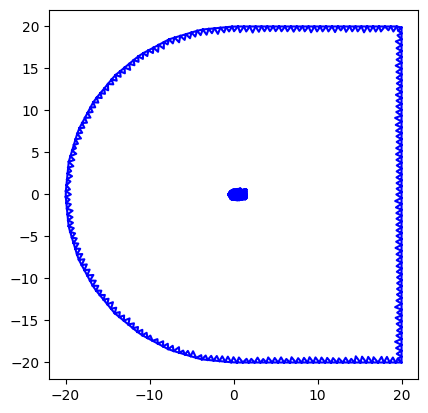

In [24]:
test_mesh_data_lists = [copy.deepcopy(test_mesh_data_list) for _ in range(10)]
print(num_trial)
loss_list = []
trial = 0
for trial in range(num_trial):
    writer = SummaryWriter(log_dir="/mnt/log/test" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f"trial{trial}")
    for epoch in tqdm(range(num_test_epoch)):
        test(device, trial)

        
        for i in range(num_test_mesh):
            save_mesh(test_mesh_data_lists[trial][i], f"{test_vtk_filenames[i]}_trial{trial}_epoch{epoch}")
    writer.close()

In [ ]:
best_mesh_data_list = []
best = []
for i in tqdm(range(num_test_mesh)):
    q_hat_list = []
    for j in range(num_trial):
        mesh = test_mesh_data_lists[j][i]

        q_hat = calculate_qhat(mesh)
        
        q_hat_list.append(q_hat)
    print(q_hat_list)
    best.append(q_hat_list.index(min(q_hat_list)))
    print(q_hat_list[best[i]])
    print("best_trial:", best[i])
    best_mesh_data_list.append(test_mesh_data_lists[best[i]][i])

    vtk_output(best_mesh_data_list[i], f"optimized_{test_vtk_filenames[i]}")
    plot_mesh(best_mesh_data_list[i], f"optimized_{test_vtk_filenames[i]}")

In [ ]:
def create_gif_from_folder_ascending(folder_path, output_path, filename, trial, duration=1000, loop=0):
    # フォルダ内のすべてのPNGファイルを取得し昇順にソート
    images = []
    file_names = [file_name for file_name in os.listdir(folder_path) if f"{filename}_trial{trial}" in file_name and file_name.endswith('.png')]   
    print(file_names)


    file_names.sort(key=lambda x: int(x.split('epoch')[1].split('.')[0]))  # ファイル名の数値部分でソート

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        images.append(imageio.imread(file_path))
    
    # GIFを作成して保存
    imageio.mimsave(output_path, images, duration=duration, loop=loop)


for i in range(num_test_mesh):
    output_path = f'/mnt/gif_folder/{test_vtk_filenames[i]}.gif'    # 出力するGIFファイルのパス
    create_gif_from_folder_ascending(fig_save_path, output_path, test_vtk_filenames[i], best[i], duration=100, loop=0)
